In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [2]:
# Robertson stiff ODE:
# y1' = -0.04 y1 + 1e4 y2 y3
# y2' =  0.04 y1 - 1e4 y2 y3 - 3e7 y2^2
# y3' =                  3e7 y2^2

def robertson_rhs(t, y):
    y1, y2, y3 = y
    dy1 = -0.04*y1 + 1e4*y2*y3
    dy2 =  0.04*y1 - 1e4*y2*y3 - 3e7*(y2**2)
    dy3 =  3e7*(y2**2)
    return [dy1, dy2, dy3]

# Jacobian J = df/dy (membantu solver stiff seperti BDF/Radau)
def robertson_jac(t, y):
    y1, y2, y3 = y
    return np.array([
        [-0.04,        1e4*y3,        1e4*y2],
        [ 0.04, -1e4*y3 - 6e7*y2,     -1e4*y2],
        [ 0.0,         6e7*y2,         0.0   ]
    ], dtype=float)


In [3]:
t0, tf = 0.0, 1e5
y0 = np.array([1.0, 0.0, 0.0], dtype=float)

# titik evaluasi: rapat di awal + logspace sampai 1e5
t_eval = np.unique(np.concatenate([
    np.linspace(0, 1, 200),
    np.logspace(0, 5, 400)
]))

rtol = 1e-6
atol = 1e-10


In [4]:
sol_bdf = solve_ivp(
    robertson_rhs, (t0, tf), y0,
    method="BDF",
    jac=robertson_jac,
    t_eval=t_eval,
    rtol=rtol, atol=atol
)

sol_radau = solve_ivp(
    robertson_rhs, (t0, tf), y0,
    method="Radau",
    jac=robertson_jac,
    t_eval=t_eval,
    rtol=rtol, atol=atol
)

print("BDF   success:", sol_bdf.success, "|", sol_bdf.message)
print("Radau success:", sol_radau.success, "|", sol_radau.message)


BDF   success: True | The solver successfully reached the end of the integration interval.
Radau success: True | The solver successfully reached the end of the integration interval.


In [5]:
def summarize_solution(name, sol):
    print(f"=== {name} ===")
    print("success :", sol.success)
    print("message :", sol.message)
    print("nfev    :", sol.nfev)
    if hasattr(sol, "njev"):
        print("njev    :", sol.njev)
    if hasattr(sol, "nlu"):
        print("nlu     :", sol.nlu)
    mass_err = np.max(np.abs(np.sum(sol.y, axis=0) - 1.0))
    print("max |(y1+y2+y3)-1| :", mass_err)
    print()

summarize_solution("BDF", sol_bdf)
summarize_solution("Radau", sol_radau)


=== BDF ===
success : True
message : The solver successfully reached the end of the integration interval.
nfev    : 895
njev    : 9
nlu     : 68
max |(y1+y2+y3)-1| : 6.661338147750939e-16

=== Radau ===
success : True
message : The solver successfully reached the end of the integration interval.
nfev    : 1483
njev    : 41
nlu     : 206
max |(y1+y2+y3)-1| : 2.220446049250313e-16



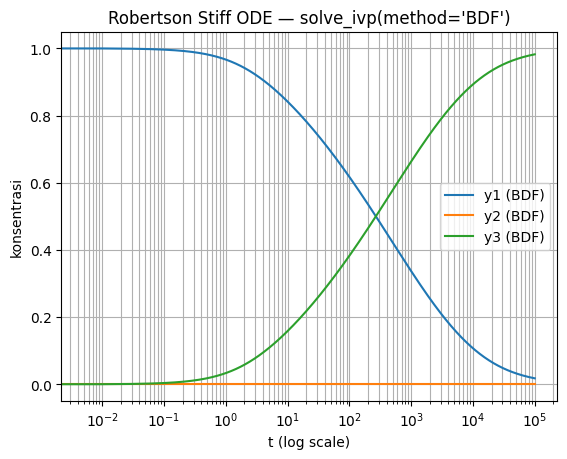

In [6]:
t = sol_bdf.t
y1, y2, y3 = sol_bdf.y

plt.figure()
plt.semilogx(t, y1, label="y1 (BDF)")
plt.semilogx(t, y2, label="y2 (BDF)")
plt.semilogx(t, y3, label="y3 (BDF)")
plt.xlabel("t (log scale)")
plt.ylabel("konsentrasi")
plt.title("Robertson Stiff ODE — solve_ivp(method='BDF')")
plt.legend()
plt.grid(True, which="both")
plt.show()


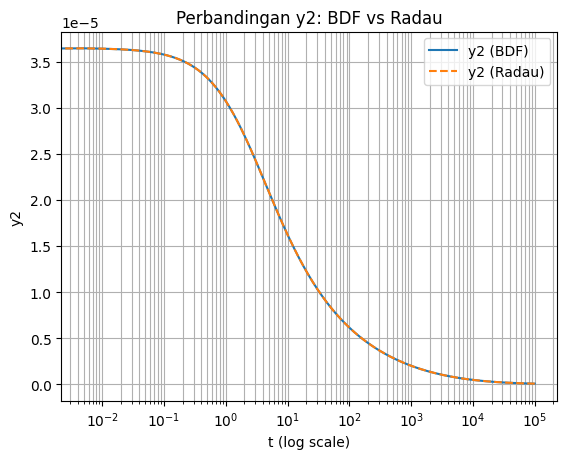

In [7]:
plt.figure()
plt.semilogx(sol_bdf.t, sol_bdf.y[1], label="y2 (BDF)")
plt.semilogx(sol_radau.t, sol_radau.y[1], "--", label="y2 (Radau)")
plt.xlabel("t (log scale)")
plt.ylabel("y2")
plt.title("Perbandingan y2: BDF vs Radau")
plt.legend()
plt.grid(True, which="both")
plt.show()
